In [ ]:
!pip install -U langchain-community


In [ ]:
import json
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.llms import Ollama

def prepare_documents(data):
    """Process data with generic error handling"""
    documents = []

    for post in data["posts"]:
        problem = post["problem"]

        # Generic error detection (not specific to any error code)
        is_error = any(kw in problem.lower() for kw in
                      ['error', 'fail', 'issue', 'not working', 'exception'])

        for sol in post["solutions"]:
            doc = Document(
                page_content=f"PROBLEM: {problem}\nSOLUTION: {sol}",
                metadata={
                    "is_error": is_error,
                    "has_code": any(x in sol for x in ['=', '(', '{', 'http']),
                    "is_screenshot": "[Technical Screenshot:" in sol,
                    "source": "dataset"
                }
            )
            documents.append(doc)
    return documents

In [ ]:


from langchain.vectorstores.base import VectorStoreRetriever
from typing import List
from langchain.schema import Document

class CustomRetriever(VectorStoreRetriever):
    def get_relevant_documents(self, query: str) -> List[Document]:
        k = 3
        is_error_query = any(kw in query.lower() for kw in
                             ['error', 'fail', 'bug', 'not working'])

        docs = self.vectorstore.similarity_search(query, k=k*2)

        if is_error_query:
            docs.sort(key=lambda x: (
                x.metadata.get("is_screenshot", False),
                x.metadata.get("has_code", False)
            ), reverse=True)

        return docs[:k]


def create_retriever(documents):
    embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(documents, embedding)
    return CustomRetriever(vectorstore=vectorstore)


/tmp/ipython-input-19-1096795745.py:5: DeprecationWarning: Retrievers must implement abstract `_get_relevant_documents` method instead of `get_relevant_documents`
  class CustomRetriever(VectorStoreRetriever):


In [ ]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

def create_qa_chain(retriever, llm):
    template = """As an OutSystems expert, provide CONCISE solutions:

{context}

Question: {question}

Answer in this EXACT format:
1. Issue Type: [Technical/General]
2. Root Cause: [1-2 sentences]
3. Immediate Fix: [Specific steps]
4. Prevention: [Best practices]
5. Resources: [Screenshots/code if available]"""

    prompt = PromptTemplate(
        template=template,
        input_variables=["context", "question"]
    )

    return RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True,
        chain_type_kwargs={
            "prompt": prompt,
            "document_separator": "\n\n---\n\n"
        }
    )

In [ ]:
def generate_solutions(user_query, qa_chain, llm):
    """Combines dataset knowledge with LLM's general knowledge"""
    # First try to find matches in dataset
    result = qa_chain.invoke({"query": user_query})
    sources = result.get("source_documents", [])

    # Calculate match quality
    has_good_match = any(
        doc.metadata["has_code"] or
        doc.metadata["is_screenshot"]
        for doc in sources
    )

    if has_good_match:
        # Format dataset-sourced answer
        answer = "🔍 [Dataset-Based Solution]\n" + result["result"]
        sources_text = "\n".join(
            f"- {doc.page_content.split('SOLUTION:')[1][:200]}..."
            for doc in sources
        )
        return {
            "answer": f"{answer}\n\n📚 Matching Solutions:\n{sources_text}",
            "source": "dataset"
        }
    else:
        # Fallback to LLM's general knowledge
        llm_response = llm.invoke(
            f"As an OutSystems expert, answer concisely: {user_query}\n"
            "Format:\n"
            "1. Likely Cause\n"
            "2. Recommended Fix\n"
            "3. Prevention Tips\n"
            "[Label this as 'General Knowledge']"
        )
        return {
            "answer": f"💡 [General Knowledge]\n{llm_response}",
            "source": "llm"
        }

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install faiss-cpu


In [ ]:
from langchain.llms import Ollama  # Add this import at the top of your file
import json
import hashlib


In [ ]:
# Run these commands in your Colab notebook before starting the interface
!curl -fsSL https://ollama.com/install.sh | sh
!nohup ollama serve &
!ollama pull phi3

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: appending output to 'nohup.out'



In [ ]:
import time
from langchain.llms import Ollama

def get_llm():
    max_retries = 3
    retry_delay = 5

    for attempt in range(max_retries):
        try:
            llm = Ollama(
                model="phi3",
                temperature=0.3,
                base_url='http://localhost:11434'
            )
            # Test connection
            llm("Test")
            return llm
        except Exception as e:
            print(f"Attempt {attempt + 1} failed, retrying...")
            time.sleep(retry_delay)

    raise ConnectionError("Failed to connect to Ollama after multiple attempts")

llm = get_llm()

In [ ]:
def initialize_qa_system():
    try:
        print("🔄 Initializing OutSystems Advisor...")
        with open('/content/drive/MyDrive/pfe/preprocessed_data (1).json') as f:
            data = json.load(f)

        documents = prepare_documents(data)
        retriever = create_retriever(documents)
        llm = Ollama(model="phi3")
        qa_chain = create_qa_chain(retriever, llm)

        print("✅ QA System Ready.\n")
        return qa_chain, llm

    except Exception as e:
        print(f"\033[1;31m❌ Initialization Failed: {str(e)}\033[0m")
        return None, None


***Enter an input message to generate its suitable solution***

In [ ]:
import json  # Assure-toi que ce module est importé

def test_interface():
    print("🔄 Initializing OutSystems Advisor...")

    try:
        with open('/content/drive/MyDrive/pfe/preprocessed_data.json') as f:
            data = json.load(f)

        documents = prepare_documents(data)
        retriever = create_retriever(documents)
        llm = Ollama(model="phi3")
        qa_chain = create_qa_chain(retriever, llm)

        print("\n✅ System Ready | Type 'exit' to quit\n")

        while True:
            user_input = input("💬 Describe your issue: ").strip()
            if user_input.lower() == 'exit':
                break

            response = generate_solutions(user_input, qa_chain, llm)

            # Color-coded output
            if response["source"] == "dataset":
                print(f"\033[1;32m{response['answer']}\033[0m")  # Green
            elif response["source"] == "llm":
                print(f"\033[1;36m{response['answer']}\033[0m")  # Blue
            else:
                print(f"\033[1;31m{response['answer']}\033[0m")  # Red

            print("\n" + "="*80 + "\n")

    except Exception as e:
        print(f"\033[1;31m❌ Initialization Failed: {str(e)}\033[0m")

# Launch
test_interface()


***BENCHMARKING : Evaluating phi-3 for a bunch of problems***

In [ ]:
import pandas as pd

def benchmark_quality(qa_chain, llm, test_cases):
    results = []

    for case in test_cases:
        query = case["query"]
        expected_keywords = case["expected_keywords"]
        response = generate_solutions(query, qa_chain, llm)
        answer = response["answer"].lower()

        matched_keywords = [kw for kw in expected_keywords if kw.lower() in answer]
        score = len(matched_keywords) / len(expected_keywords) * 100

        results.append({
            "query": query,
            "matched": len(matched_keywords),
            "total": len(expected_keywords),
            "match_score": score,
            "missing": [kw for kw in expected_keywords if kw.lower() not in answer],
            "source": response["source"],
            "answer": response["answer"]
        })

    df = pd.DataFrame(results)
    df.to_csv("/content/drive/MyDrive/pfe/benchmark_results.csv", index=False)
    print(f"📊 Final Benchmark Summary:\n🎯 Avg Match Score: {df['match_score'].mean():.2f}% over {len(df)} queries")

    return df


In [ ]:
!pip install seaborn


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_benchmark(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=df.index, y="match_score", data=df)
    plt.title("Match Score per Query")
    plt.xlabel("Query Index")
    plt.ylabel("Match Score (%)")
    plt.ylim(0, 100)
    plt.axhline(df["match_score"].mean(), color='red', linestyle='--', label='Average')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Pie chart of source usage
    plt.figure(figsize=(6, 6))
    df["source"].value_counts().plot.pie(autopct="%1.1f%%", colors=["lightgreen", "skyblue"])
    plt.title("Answer Source Distribution")
    plt.ylabel("")
    plt.show()


🔄 Initializing OutSystems Advisor...


/tmp/ipython-input-19-1096795745.py:23: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warning

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ QA System Ready.

📊 Final Benchmark Summary:
🎯 Avg Match Score: 86.67% over 10 queries


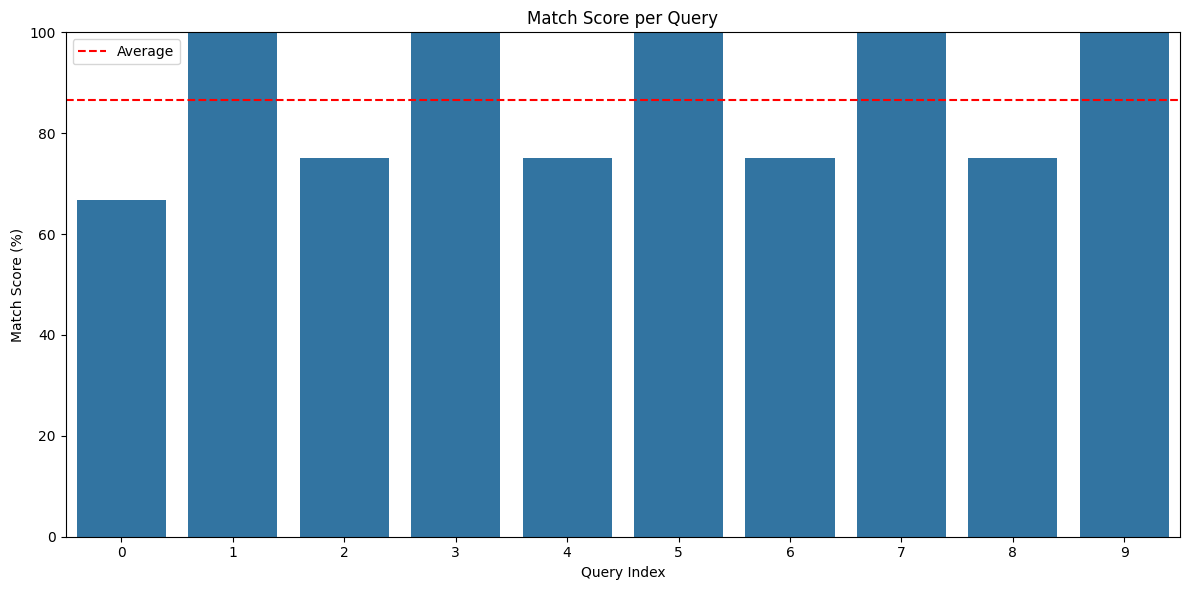

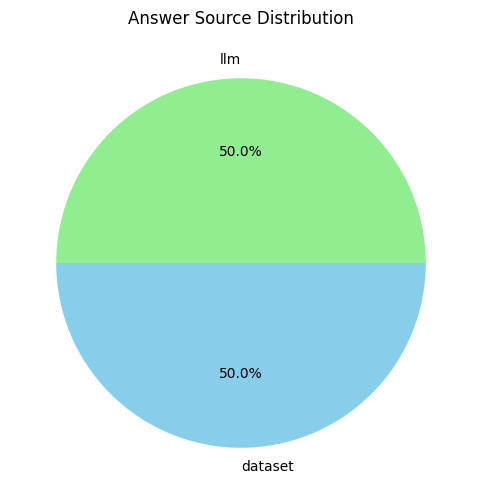

In [ ]:
with open('/content/drive/MyDrive/pfe/benchmark_cases.json') as f:
    test_cases = json.load(f)
qa_chain, llm = initialize_qa_system()
df = benchmark_quality(qa_chain, llm, test_cases)
visualize_benchmark(df)
